# VQGAN

Мультимодальные языковые модели - это одно из самых горячих направлений исследований. Модели, которые обучены на всех доступных текстах, уже показывают очень впечатляющие результаты и постепенно находят все больше применений. Но очевидно, что только текста недостаточно и нужно научить модель видеть. А в идеале еще и выражать свои мысли не только текстом, но и визуально. Топовые лаборатории и компании уже достаточно длительное время имеют модели, которые могут понимать картинки (и иногда видео) и недавно начали появляться модели, которые могут генерировать картики. И, кажется, что это не ансабль моделей, где LLM пишет промпты для диффузионной модели, а одна end-to-end модель, которая может генерировать текстовые и визуальные токены! Хороших открытых моделей, которые так умеют пока что нет, но есть ранние работы (как например вот эта - https://arxiv.org/pdf/2405.09818), которые позволяют понять, как это может работать. 
Так как это большая, сложная и новая тема, давайте попробуем разбить ее на части. Один из основных компонетнов для таких полностью мультимодальных моделей - это превращение картинок в визуальные токены, чтобы затем использовать уже работающие подходы к языковому моделированию. Нужно уметь превратить картинку в токены, а затем превратить визуальные токены сгенерированные моделью в пиксели. Чтобы понять как это работает, давайте пройдемся по имплементации VQGAN. Это чисто картиночная работа, но в результате обучения как раз получается энкодер и декодер, который можно связать с GPT-like моделью. 

Код я взял отсюда - https://github.com/dome272/VQGAN-pytorch

У автора также есть разбор статьи (https://www.youtube.com/watch?v=wcqLFDXaDO8) и детальный разбор кода (https://www.youtube.com/watch?v=_Br5WRwUz_U)

Я перенес код в ноутбук, чтобы было проще по нему пройтись на семинаре и добавил комментариев, чтобы было понятно, что происходит. 
Для меня это тоже новая и неизвестная тема, поэтому давайте разбираться вместе!

### Как устроен VQGAN

![](https://compvis.github.io/taming-transformers/paper/teaser.png)


Vqgan - это дверь в большой мир компьютерного зрения и тут много очень специфичных вещей. Попробуем все разобрать, но не очень детально, потому что нам тут важен сам результат. 

Во-первых, VQGAN это автоэнкодерная модель. Такие модели используются для создания векторных представлений, которые кодируют важную информацию из картинки. С картинками вообще почти никогда не работают как с сырыми пикселями (потому что их слишком много), а превращают их в более компактные векторные представления.  

Автоэнкодер состоит из энкодера и декодера. Энкодер обрабытывает изначальную картинку и выдает сжатое векторное представление. Декодер используется векторное представление и пытается восстановить изначальную картинку. Качество оценивается через сравнение восстановленной картинки с изначальной. Чем лучше и полнее энкодер кодирует информацию, тем легче будет декодеру. В практических задачах часто используется только декодер, чтобы получить качественное представление и затем делать с ним что-то еще. Но нам понадобится и декодер. 

Помимо этого, VQGAN - это генеративная состязательная сеть (generative adversarial network, GAN). К энкодеру и декодеру добавляется сеть дискриминатор, которая учиться отличать настоящие картинки от восстановленных (сгенерированных). Это заставляет модель учиться генерировать реалистичные картинки. Так как дискриминатор тоже обучается, он может подстраиваться под паттерны, которые генерирует декодер и заставлять модель подстраиваться. 

VQ в название означает vector quantization и это самая важная для нас часть. В обычном автоэнкодере модель просто предсказывает эмбеддинг напрямую, но это работает не очень хорошо. Модель слишком привязывается к единичным примерfv в обучающей выборке и получаемые векторы для похожих, но отличающихся картинок, могут сильно расходится. Для того, чтобы это исправить придумали VAE (Variational Auto Encoder, статья разбор https://mbernste.github.io/posts/vae/), где для картинки предсказывается вероятностное распределение, из которого можно засемплировать итоговый вектор. Пространство векторов таким образом получается более плавным и VAE позволяют, например, исследовать векторные пространства, слегка изменяя вектор и смотря, что получится у декодера (можно так плавно переходить от изображения собаки к изображению человека например). В статье VQ-VAE (разбор - https://www.youtube.com/watch?v=VZFVUrYcig0) авторы предложили учить диксретные представления. Для этого они добавили часть, которая называется codebook. Это такая обучаемая таблица эмбедингов с фиксированным размером и вместо того, чтобы брать вектор, который вернул энкодер, находится самый ближайший вектор в этой таблице. Квантизация состоит в том, что вместо вектора из энкодера мы получаем индекс ближайшего вектора в codebook таблице. По сути codebook - это словарь! Такой же как мы использовали для токенов в тексте. То есть в декодер будет подаваться последовательность индексов (токенов!), которые описывают картинку. В отличие от тектовых токенов, токены из codebook нельзя напрямую перевести в пиксели - это абстрактные вектора, которые кодируют какие-то понятния в картинке. Но декодер позволяет взять последовательность таких токенов и сделать из них целую картинку. VQGAN соответственно улучшил VQVAE за счет добавления дикриминатора, чтобы улучшить качество. 

Последний элемент на картинке - это внезапно трансформер. И это то, что связывает автоэкодеры и компьютерное зрение с NLP. В результате обучаения VQGAN получается энкодер, декодер и codebook. Можно представить картинку как последовательность визуальных токенов и из последовательности визуальных токенов получить картинку. Там где есть последовательность, можно применить трансформер для генерации! И это то, что сделали авторы VQ-VAE и VQGAN - используя, готовый энкодер и codebook они токенизировали картинки и обучили языковую модель предсказывать следующий визуальный токен. Такой обученный трасформер уже можно использовать по отдельности для генерации новых случайных картинок - сначала трансформер генерирует последовательность визуальных токенов, а затем она пропускается через декодер, чтобы получить финальную картинку. 

Если развить эту идею дальше, то можно попробовать совместить картиночные токены и обычные текстовые в одной модели! Таким образом она будет понимать и картинки и текст и отвечать сможет также и текстом и картинками! Но про это мы поговорим на следующем занятии, а пока давайте пройдемся по коду для VQGAN!

In [1]:
import os
import argparse
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import utils as vutils
import torch.nn as nn
import albumentations
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.models import vgg16
from collections import namedtuple
import requests
import math
from torchvision import utils as vutils

В качестве данных можно взять любой картиночный датасет. Автор этого туториала использует классический датасет с цветами - https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

Этот класс загружает картинки и применяет к ним стандартную предобработку. Тут еще используется библиотека `albumentations`, в которой реализованы многие виды аугментации для картинок

In [ ]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
# !tar -xvzf 102flowers.tgz

In [2]:
class ImagePaths(Dataset):
    def __init__(self, path, size=None):
        self.size = size

        self.images = [os.path.join(path, file) for file in os.listdir(path)]
        self._length = len(self.images)

        # картинка сжимается или растягивается так чтобы максимальная сторона была меньше заданного лимита
        # но соотношение сторон сохранилось 
        # например (1024,512) при лимите в 512 сожмется до (512, 256)
        self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
        # в cv любят работать с квадратными картинками
        # поэтому из изначальной картинки тут вырезается центральная квадратная часть 
        self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
        self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])

    def __len__(self):
        return self._length

    def preprocess_image(self, image_path):
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        return image

    def __getitem__(self, i):
        example = self.preprocess_image(self.images[i])
        return example

def load_data(args):
    train_data = ImagePaths(args.dataset_path, size=256)
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
    return train_loader


Эта функци просто будет показывать картинки, которые сгенерирует трансформер

In [3]:
def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()

Энкодер и декодер модели в основном построены на сверточных нейронных сетях. В дополнение к Conv2d там также есть слои для нормализации и активации (в этом случае используется Swish которая похожа на сигмоиду)
Также как в стандартных CNN архитектурах и также как в трансформерах тут активно используются residual связи. 

In [16]:
# # эта функция 
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)
    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            # из-за того что кернел сайз = 3, то длина размер сократится на 2
            # если добавить по одному паддингу с каждой стороны (то есть 2) то в итоге размер сохранится
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)

Также стандартно для CNN, энкодер постепенно сжимает картинку, а декодеру в результате нужно увеличить вектор в размерность итоговой картинки 

In [17]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # интерполяция просто увеличивает размерность в два раза
        # значения подставляются за счет усреднения соседних значений
        x = F.interpolate(x, scale_factor=2.0)
        # cnn слой обрабатывает увеличенную в размере картинку
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        # из-за того что stride=2 размер уменьшиться в два раза
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        # в нечетных размерах деление на два будет неточным, поэтому тут делается паддинг сверху и справа
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)

Тут также используется элемент из трансформера для того, чтобы обогатить локальные представления глобальным контексто. 
Преобразования тут реализованы не через полновсвязнные слои, а через сверточные. Но обратите внимание что `kernel_size=1` это означает, что на самом деле каждый фильтр применяет только к одному элементу и между отдельные элементы никак не взаимодействуют между собой (каждый пиксель преобразуется по отдельности). Это то же самое, что применить полносвязный слой!  

In [6]:
class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

Этот кусок взят из другой статьи про perceptual loss. Тут используется предобученная cv модель VGG для сопоставления изначальной картинки и восстановленной. Эта модель сравнивает эмбеддинги для настоящей и сгенерированной картинки и выдает разницу как лосс. Как я понимаю, идея в том, что между картинками можно напрямую рассчитать попиксельную разницу, но она не будет соответствовать тому, как мы бы оценили разницу глазами, поэтому используется предобученная модель и ее результаты гораздно ближе к тому как мы воспринимаем разницу.

In [7]:
URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}

In [8]:
def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path

In [9]:
class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )

In [10]:
vgg16(pretrained=True).features

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [11]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        # в этом модели последовательно стоят блоки со свертками/пулингом и активациями 
        # и каждый пятый слой выдает результат активации
        # тут вместо последнего вектора берутся результаты промежуточных аквтиваций тоже
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

## Encoder

Энкодер это просто много сверток. Тут используются слои определенные выше и они просто собираются в одну длинную модель

In [14]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [18]:
class test_args:
    image_channels = 3
    latent_dim = 256
e = Encoder(test_args).eval()

Encoder принимает на вход картинку и преобразует ее. Если на вход подать картинку размером 512x768x3 то на выходе получится представление 32x48x256. Оно уже меньше по размеру, но размер все еще сохраняется двумерный и поэтому дальше везде используются Conv2D, так как они по умолчанию работают с 2d представлениями и не нужно самому делать постоянные решейпы.

In [19]:
e(torch.rand((1, 3, 512, 768))).shape

torch.Size([1, 256, 32, 48])

In [20]:
# на вход можно подавать разные картинки
e(torch.rand((1, 3, 256, 768))).shape

torch.Size([1, 256, 16, 48])

Декодер делает все наоборот - принимает сжатое представление и повышает его до картиночных размеров. И вместо внутренней размерности признаков в итоге все приходит к 3 rgb каналам

In [21]:
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16

        in_channels = channels[0]
        layers = [nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [22]:
d = Decoder(test_args).eval()

In [23]:
i = d(e(torch.rand((1, 3, 512, 768))))
i.shape

torch.Size([1, 3, 512, 768])

Можно даже визуализировать такой тензор так как это уже по сути картинка

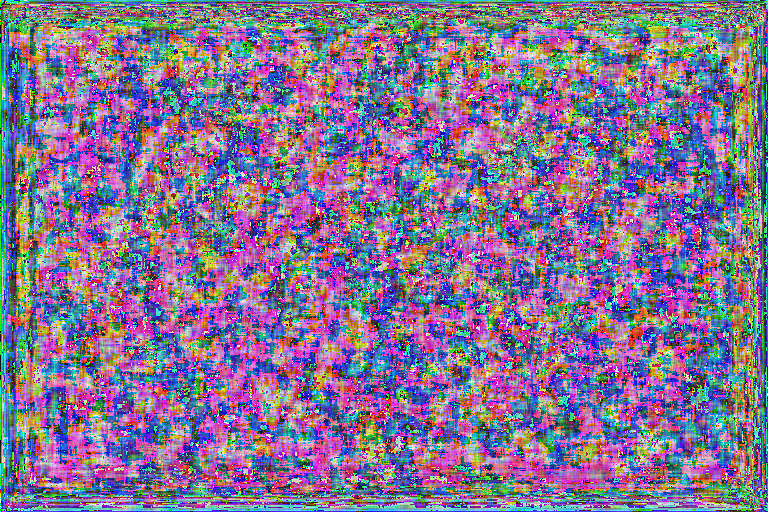

In [24]:
Image.fromarray((i[0].permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8))

## cookbook

Cookbook совсем небольшой но сложный)
Из слоев тут есть только Embedding (он еще отдельно инициализируется но это не так важно)
Вся сложноть происходит в forward. Сначала представление просто расрезается на несколько отдельных векторов размерности равной векторам в embedding таблице

Далее между этими векторами и векторами в таблице считается близость (тут squared euclidean distance) и выбираются индексы самых ближайших для каждого из векторов. Затем берутся сами эмбединги по этим индексам.
А дальше происходит трюк с рассчитыванием лосса. Так как argmin не дифференцируемая операция, то для того, чтобы обновить и сами cookbook вектора и энкодер, который произвел векторные представление, лосс рассчитывается с домощью detach(). Как я понимаю таким образом codebook не попадет в вычислительный граф, который идет от энкодера, а в codebook не попадет часть от энкодера, но они все равно будут влиять друг на друга. 

In [25]:
class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args.num_codebook_vectors
        self.latent_dim = args.latent_dim
        self.beta = args.beta

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous() # contiguous creates a copy, not just resize the original z
        z_flattened = z.view(-1, self.latent_dim)

        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss

In [27]:
class test_args_cookbook:
    beta = 0.25
    latent_dim = 256
    num_codebook_vectors = 1024

cb = Codebook(test_args_cookbook).eval()

In [37]:
r = cb(e(torch.rand((1, 3, 324, 256))))

In [38]:
# векторное представление для декодера
r[0].shape

torch.Size([1, 256, 20, 16])

In [39]:
# последовательность токенов, которые кодируют картинку
r[1]

tensor([833, 495, 722, 722,  76, 575, 254, 495,  21, 336,  76, 254, 471,  18,
        425, 629, 739, 629, 489, 980, 254, 905, 258, 980,  76, 980, 254, 254,
        254, 980, 980, 629, 900, 495,  76, 980, 262, 980, 980, 495, 980, 980,
        738, 495, 980, 980,  76, 666, 733, 254, 980, 489, 980,  93, 980, 980,
        980, 980, 607, 358, 254, 254,  76, 722, 674, 597, 980, 980, 262,  93,
        980,  76, 980, 489, 254, 520,  93, 980, 980, 830, 358, 597, 830, 597,
         76, 980, 980, 358, 597, 980, 980, 980, 254, 980,  76, 666, 733, 980,
        520, 980, 495, 495, 489, 489, 336, 980, 980, 980,  93, 489, 980, 830,
        225, 489,  76, 980, 358, 980, 980, 980, 495,  76, 980, 980, 980, 262,
        980, 950, 739,  76, 980, 375, 492, 980,  21,  76, 980, 375, 489, 980,
        980,  76, 980, 950, 254, 980, 489, 134, 980,  76, 980, 258, 489, 980,
        980, 980, 597, 495, 980, 629, 492, 980, 308, 258, 520, 905,  93, 980,
        739, 980, 980,  76, 471, 980, 722, 950, 492, 980, 980, 9

In [40]:
r[2]

tensor(0.1420, grad_fn=<AddBackward0>)

Дискриминатор это не просто бинарный классификатор, который говорит настоящая картинка в целом или нет. Это тоже сверточная сеть, которая выдает сразу несколько скоров для отдельных кусков изображения.

In [42]:

class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(args.image_channels, num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [43]:
class test_args_descr:
    image_channels = 3

desc = Discriminator(test_args_descr).eval()

In [44]:
i = d(e(torch.rand((1, 3, 512, 768))))

In [47]:
i.shape

torch.Size([1, 3, 512, 768])

In [48]:
# целый grid скоров который показывает насколько картинка настоящая 
desc(i).shape

torch.Size([1, 1, 62, 94])

In [49]:
desc(i)

tensor([[[[-0.0022, -0.0062, -0.0030,  ..., -0.0076, -0.0063, -0.0051],
          [-0.0081, -0.0071, -0.0031,  ...,  0.0005, -0.0047, -0.0055],
          [-0.0054, -0.0050,  0.0003,  ...,  0.0027, -0.0067,  0.0010],
          ...,
          [-0.0051, -0.0007, -0.0021,  ..., -0.0038, -0.0043, -0.0094],
          [ 0.0023,  0.0035, -0.0001,  ...,  0.0033, -0.0074, -0.0091],
          [ 0.0004,  0.0066,  0.0067,  ...,  0.0052,  0.0021, -0.0018]]]],
       grad_fn=<ConvolutionBackward0>)

Все вместе. Тут тоже есть хитрости с тем, чтобы градиенты дошли до энкодера, а также есть дополнительные параметры для взвешивания отдельных частей общего лосса

In [64]:
class VQGAN(nn.Module):
    def __init__(self, args):
        super(VQGAN, self).__init__()
        self.encoder = Encoder(args).to(device=args.device)
        self.decoder = Decoder(args).to(device=args.device)
        self.codebook = Codebook(args).to(device=args.device)
        self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)
        self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)

    def forward(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
        decoded_images = self.decoder(post_quant_conv_mapping)

        return decoded_images, codebook_indices, q_loss

    def encode(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping = self.post_quant_conv(z)
        decoded_images = self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, perceptual_loss, gan_loss):
        last_layer = self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        λ = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + 1e-4)
        λ = torch.clamp(λ, 0, 1e4).detach()
        return 0.8 * λ

    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value=0.):
        if i < threshold:
            disc_factor = value
        return disc_factor

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))

In [63]:
class TrainVQGAN:
    def __init__(self, args):
        self.vqgan = VQGAN(args).to(device=args.device)
        self.discriminator = Discriminator(args).to(device=args.device)
        # self.discriminator.apply(weights_init)
        self.perceptual_loss = LPIPS().eval().to(device=args.device)
        self.opt_vq, self.opt_disc = self.configure_optimizers(args)

        self.prepare_training()

        self.train(args)

    def configure_optimizers(self, args):
        lr = args.learning_rate
        opt_vq = torch.optim.Adam(
            list(self.vqgan.encoder.parameters()) +
            list(self.vqgan.decoder.parameters()) +
            list(self.vqgan.codebook.parameters()) +
            list(self.vqgan.quant_conv.parameters()) +
            list(self.vqgan.post_quant_conv.parameters()),
            lr=lr, eps=1e-08, betas=(args.beta1, args.beta2)
        )
        opt_disc = torch.optim.Adam(self.discriminator.parameters(),
                                    lr=lr, eps=1e-08, betas=(args.beta1, args.beta2))

        return opt_vq, opt_disc

    @staticmethod
    def prepare_training():
        os.makedirs("results", exist_ok=True)
        os.makedirs("checkpoints", exist_ok=True)

    def train(self, args):
        train_dataset = load_data(args)
        steps_per_epoch = len(train_dataset)
        for epoch in range(args.epochs):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    imgs = imgs.to(device=args.device)
                    decoded_images, _, q_loss = self.vqgan(imgs)

                    disc_real = self.discriminator(imgs)
                    disc_fake = self.discriminator(decoded_images)

                    disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                    perceptual_loss = self.perceptual_loss(imgs, decoded_images)
                    rec_loss = torch.abs(imgs - decoded_images)
                    perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                    perceptual_rec_loss = perceptual_rec_loss.mean()
                    g_loss = -torch.mean(disc_fake)

                    λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                    vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                    d_loss_real = torch.mean(F.relu(1. - disc_real))
                    d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                    gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                    self.opt_vq.zero_grad()
                    vq_loss.backward(retain_graph=True)

                    self.opt_disc.zero_grad()
                    gan_loss.backward()

                    self.opt_vq.step()
                    self.opt_disc.step()

                    if i % 10 == 0:
                        with torch.no_grad():
                            real_fake_images = torch.cat((imgs[:4], decoded_images.add(1).mul(0.5)[:4]))
                            vutils.save_image(real_fake_images, os.path.join("results", f"{epoch}_{i}.jpg"), nrow=4)

                    pbar.set_postfix(
                        VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                        GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                    )
                    pbar.update(0)
                torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_epoch_{epoch}.pt"))

In [17]:
class Args:
    latent_dim = 256
    image_size = 256
    num_codebook_vectors = 1024
    beta = 0.25
    image_channels = 3
    dataset_path = "./jpg"
    device = "cuda"
    batch_size = 6
    epochs = 100
    learning_rate = 2.25e-05
    beta1 = 0.5
    beta2 = 0.9
    disc_start = 10000
    disc_factor = 1.0
    rec_loss_factor = 1.0
    perceptual_loss_factor = 1.0
args = Args()

Обучается модель достаточно долго. Можно смотреть на генерируемые картинки, чтобы понимать когда она начнет выдавать что-то нормальное

In [18]:
train_vqgan = TrainVQGAN(args)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  3%|▎         | 44/1365 [00:24<12:04,  1.82it/s, GAN_Loss=0, VQ_Loss=0.157]    


KeyboardInterrupt: 

Дальше обученную модель можно использовать, чтобы обучить трансформер. Тут используется код из minigpt, который написан Karpathy и очень похож на код, который мы использовали для обучения GPT. Помимо просто обучения на предсказании следующего токена, тут используется маскирование случайного количества токенов, чтобы модель восстанавливала их

In [51]:
class VQGANTransformer(nn.Module):
    def __init__(self, args):
        super(VQGANTransformer, self).__init__()

        self.sos_token = args.sos_token

        self.vqgan = self.load_vqgan(args)

        transformer_config = {
            "vocab_size": args.num_codebook_vectors,
            "block_size": 512,
            "n_layer": 24,
            "n_head": 16,
            "n_embd": 1024
        }
        self.transformer = GPT(**transformer_config)

        self.pkeep = args.pkeep

    @staticmethod
    def load_vqgan(args):
        model = VQGAN(args)
        model.load_checkpoint(args.checkpoint_path)
        model = model.eval()
        return model

    @torch.no_grad()
    def encode_to_z(self, x):
        quant_z, indices, _ = self.vqgan.encode(x)
        indices = indices.view(quant_z.shape[0], -1)
        return quant_z, indices

    @torch.no_grad()
    def z_to_image(self, indices, p1=16, p2=16):
        ix_to_vectors = self.vqgan.codebook.embedding(indices).reshape(indices.shape[0], p1, p2, 256)
        ix_to_vectors = ix_to_vectors.permute(0, 3, 1, 2)
        image = self.vqgan.decode(ix_to_vectors)
        return image

    def forward(self, x):
        _, indices = self.encode_to_z(x)

        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")

        mask = torch.bernoulli(self.pkeep * torch.ones(indices.shape, device=indices.device))
        mask = mask.round().to(dtype=torch.int64)
        random_indices = torch.randint_like(indices, self.transformer.config.vocab_size)
        new_indices = mask * indices + (1 - mask) * random_indices

        new_indices = torch.cat((sos_tokens, new_indices), dim=1)

        target = indices

        logits, _ = self.transformer(new_indices[:, :-1])

        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float("inf")
        return out

    @torch.no_grad()
    def sample(self, x, c, steps, temperature=1.0, top_k=100):
        self.transformer.eval()
        x = torch.cat((c, x), dim=1)
        for k in range(steps):
            logits, _ = self.transformer(x)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                logits = self.top_k_logits(logits, top_k)

            probs = F.softmax(logits, dim=-1)

            ix = torch.multinomial(probs, num_samples=1)

            x = torch.cat((x, ix), dim=1)

        x = x[:, c.shape[1]:]
        self.transformer.train()
        return x

    @torch.no_grad()
    def log_images(self, x):
        log = dict()

        _, indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")

        start_indices = indices[:, :indices.shape[1] // 2]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1] - start_indices.shape[1])
        half_sample = self.z_to_image(sample_indices)

        start_indices = indices[:, :0]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1])
        full_sample = self.z_to_image(sample_indices)

        x_rec = self.z_to_image(indices)

        log["input"] = x
        log["rec"] = x_rec
        log["half_sample"] = half_sample
        log["full_sample"] = full_sample

        return log, torch.concat((x, x_rec, half_sample, full_sample))

In [52]:
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            setattr(self, k, v)


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        mask = torch.tril(torch.ones(config.block_size,
                                     config.block_size))
        if hasattr(config, "n_unmasked"):
            mask[:config.n_unmasked, :config.n_unmasked] = 1
        self.register_buffer("mask", mask.view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        present = torch.stack((k, v))
        if layer_past is not None:
            past_key, past_value = layer_past
            k = torch.cat((past_key, k), dim=-2)
            v = torch.cat((past_value, v), dim=-2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if layer_past is None:
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, present  # TODO: check that this does not break anything

In [65]:
class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),  # nice
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x, layer_past=None, return_present=False):
        # TODO: check that training still works
        if return_present:
            assert not self.training
        # layer past: tuple of length two with B, nh, T, hs
        attn, present = self.attn(self.ln1(x), layer_past=layer_past)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        if layer_past is not None or return_present:
            return x, present
        return x


class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, vocab_size, block_size, n_layer=12, n_head=8, n_embd=256,
                 embd_pdrop=0., resid_pdrop=0., attn_pdrop=0., n_unmasked=0):
        super().__init__()
        config = GPTConfig(vocab_size=vocab_size, block_size=block_size,
                           embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop,
                           n_layer=n_layer, n_head=n_head, n_embd=n_embd,
                           n_unmasked=n_unmasked)
        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))  # 512 x 1024
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)
        self.config = config

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, embeddings=None):
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector

        if embeddings is not None:  # prepend explicit embeddings
            token_embeddings = torch.cat((embeddings, token_embeddings), dim=1)

        t = token_embeddings.shape[1]
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        position_embeddings = self.pos_emb[:, :t, :]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        return logits, None

In [66]:
class TrainTransformer:
    def __init__(self, args):
        self.model = VQGANTransformer(args).to(device=args.device)
        self.optim = self.configure_optimizers()

        self.train(args)

    def configure_optimizers(self):
        decay, no_decay = set(), set()
        whitelist_weight_modules = (nn.Linear, )
        blacklist_weight_modules = (nn.LayerNorm, nn.Embedding)

        for mn, m in self.model.transformer.named_modules():
            for pn, p in m.named_parameters():
                fpn = f"{mn}.{pn}" if mn else pn

                if pn.endswith("bias"):
                    no_decay.add(fpn)

                elif pn.endswith("weight") and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)

                elif pn.endswith("weight") and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)

        no_decay.add("pos_emb")

        param_dict = {pn: p for pn, p in self.model.transformer.named_parameters()}

        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.01},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]

        optimizer = torch.optim.AdamW(optim_groups, lr=4.5e-06, betas=(0.9, 0.95))
        return optimizer

    def train(self, args):
        train_dataset = load_data(args)
        for epoch in range(args.epochs):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    self.optim.zero_grad()
                    imgs = imgs.to(device=args.device)
                    logits, targets = self.model(imgs)
                    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
                    loss.backward()
                    self.optim.step()
                    pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
                    pbar.update(0)
            log, sampled_imgs = self.model.log_images(imgs[0][None])
            vutils.save_image(sampled_imgs, os.path.join("results", f"transformer_{epoch}.jpg"), nrow=4)
            plot_images(log)
            torch.save(self.model.state_dict(), os.path.join("checkpoints", f"transformer_{epoch}.pt"))

In [67]:
class Args:
    latent_dim = 256
    image_size = 256
    num_codebook_vectors = 1024
    beta = 0.25
    image_channels = 3
    dataset_path = "./jpg"
    checkpoint_path = './checkpoints/vqgan_epoch_14.pt'
    device = 'cuda'
    batch_size = 10
    epochs = 100
    learning_rate = 2.25e-05
    beta1 = 0.5
    beta2 = 0.9
    disc_start = 10000
    disc_factor = 1.0
    l2_loss_factor = 1.0
    perceptual_loss_factor = 1.0
    pkeep = 0.5
    sos_token = 0

In [61]:
# ls checkpoints/

Трасформер для генерации сильно зависит от изначальной модели. Если она еще не дооучилась, то и трансформер будет генерировать плохие картинки

100%|██████████| 819/819 [05:41<00:00,  2.40it/s, Transformer_Loss=2.65]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.10151..2.1534388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.2193613..2.196927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1631994..1.3570906].


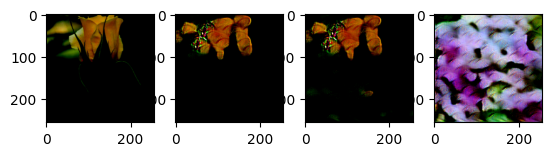

100%|██████████| 819/819 [05:42<00:00,  2.39it/s, Transformer_Loss=2.61]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.10151..2.1534388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1995463..2.2672443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4481777..1.2426817].


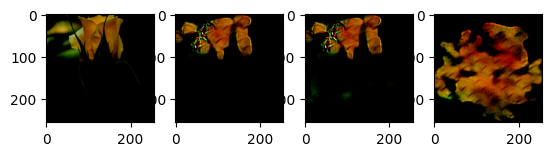

  5%|▍         | 39/819 [00:16<05:25,  2.39it/s, Transformer_Loss=2.59]

In [ ]:
args = Args
train_transformer = TrainTransformer(args)